In [1]:
# References
# https://medium.com/swlh/introduction-to-cnn-image-classification-using-cnn-in-pytorch-11eefae6d83c
# https://towardsdatascience.com/how-i-built-a-face-mask-detector-for-covid-19-using-pytorch-lightning-67eb3752fd61
# https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
# https://core.ac.uk/reader/328808130

In [2]:
# Importing libraries
import os
import cv2
import torch
import itertools
import numpy as np
import torch.nn as nn
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToPILImage, Compose, ToTensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

In [3]:
# Path of training and testing dataset
drive.mount('/content/drive') # comment out while running locally
dir_path = "/content/drive/My Drive/COMP-6721-AI-Project/Dataset" # update directory path for local directory
mask_dir = "{}/person_with_mask".format(dir_path)
non_mask_dir = "{}/person".format(dir_path)
not_person_dir = "{}/not_person".format(dir_path)
procesed_dir = "{}/processed_data.npy".format(dir_path) # stored pre-processed data as npy file for running again
save_model_name = "ai-project-1"

Mounted at /content/drive


In [4]:
# Labels (classes) to differentiate the images in these categories
label_dict = {
    0: "Person with Face Mask", 
    1: "Person without Face Mask", 
    2: "Not a Person"
}

# Labels to display on the confussion matrix
labels_list = ["Person with Face Mask", "Person without Face Mask", "Not a Person"]

In [5]:
# Customized dataset class named ProjectDataset which is inherited
# from Dataset class of pytorch, the purpose of inheritance here is 
# to store the labels(keys) of images with the image ndarray this way we
# can remove the problem of overfitting. This overfitting problem was there
# when initially project implementation started as we have purposely devided
# images of different lables/classes in different directories.
class ProjectDataset(Dataset):

    def __init__(self, data):
        self.data = data
        self.transformations = Compose([
            ToTensor()
        ])

    def __getitem__(self, key):
        item_list = []
        try:
            item_list.append(self.transformations(self.data[key][0]))
            item_list.append(torch.tensor(self.data[key][1]))
        except Exception:
            pass
        return item_list

    def __len__(self):
        return self.data.__len__()

In [6]:
# Customized convolution neural network class which is again inherited from the torch
# neural network class. this class contains all the filters and other operations
# which are performed on images. The class contains forward method which is used to
# feedforward the neural network and the backpropogation.
class COMP_6721_CNN(nn.Module):
    
    def __init__(self):
        super(COMP_6721_CNN, self).__init__()
        self.cnn_layers = nn.Sequential(
            # convolution layer 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # convolution layer 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # convolution layer 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(36864, 3)
        )

    # forward pass to readjust weights  
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [7]:
# This function takes empty data as list, directory path to find the dataset
# location and key which used to describe the category of image (0, 1, 2) based 
# on the which class it belongs. after converting images into an array the function
# will return all the array within list to process further.
def load_images(data, dir_path, key):
    print("=== Loading Images ===")
    for file_path in os.listdir(dir_path):
        try:
            temp_img = cv2.resize(cv2.imread("{}/{}".format(dir_path, file_path), cv2.IMREAD_COLOR), (100, 100))
            data.append([np.array(temp_img), key])
        except Exception as e:
            pass
    return data

In [8]:
# This function takes image data as a list and saving data directory path and after
# shuffling the data, it will store numpy array at the specific directory.
def shuffle_and_save_data(data, save_data_dir):
    print("=== Shuffel Images ===")
    np.random.shuffle(data)
    np.save(save_data_dir, data)

In [9]:
# This function takes process and stored data dictionary path, after reading data
# from the given path, the function distributes data across training and testing data category.
# It combines all the data with a key and returns a dictionary for the further use.
def load_and_distribute_data(procesed_dir):
    print("=== Loading and Distributing Images across Training and Testing data ===")
    loaded_data = np.load(procesed_dir, allow_pickle=True)
    training_data, testing_data = train_test_split(loaded_data, test_size=0.2, random_state=0)
    distributed_data = {
        "training_data": training_data,
        "testing_data": testing_data
    }
    return distributed_data

In [10]:
# This function takes a dictionary of keys (label classes) along with the
# data for all clasess and builds the loader for each training and testing
# category and returns it for further use.
def build_dataset_loaders(distributed_data):
    print("=== Bulding Data Loaders ===")
    training_dataset = ProjectDataset(distributed_data.get("training_data"))
    test_dataset = ProjectDataset(distributed_data.get("testing_data"))
    train_loader = DataLoader(training_dataset, batch_size=128)
    test_loader = DataLoader(test_dataset, batch_size=128)
    return train_loader, test_loader

In [11]:
# This function takes training data and returns a normalized list based on
# number of data falls into each category/label (classes) which is used while
# building a loss criteria.
def normalized_weights_to_build_loss_criteria(training_data):
    print("=== Normalizing weights accorss all Label classes ===")
    # Dict to count number of training images across the different classes
    # for normalization purpose
    training_data_count_dict = {
        0: 0,
        1: 0,
        2: 0
    }
    normalization_values = []
    for data in training_data:
        training_data_count_dict.update({data[1]: training_data_count_dict.get(data[1])+1})
    categorized_value_list = list(training_data_count_dict.values())
    total_counts = sum(categorized_value_list)
    for category_value in categorized_value_list:
        key_value = (1 - (category_value / total_counts))
        normalization_values.append(key_value)
    return normalization_values

In [12]:
# This function takes a device and normalizeed list to build a model.
def build_model(device, normalization):
    print("=== Bulding Model ===")
    model = COMP_6721_CNN()
    model = model.to(device)
    loss_criteria = nn.CrossEntropyLoss(weight=torch.tensor(normalization).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    return model, optimizer, loss_criteria

In [13]:
# This function takes a model, optimizer, loss_criteria and training loader to 
# train the model, after multiple epoches, model gets stablize and function return
# the model to use it for evaluation.
def train_model(model, optimizer, loss_criteria, train_loader):
    print("=== Training Model ===")
    for i in range(10):
        model.train()
        training_accuracy_list = []
        training_loss_list = []

        for data_chunk in train_loader:
            images, labels = data_chunk
            outputs = model(images)
            training_loss = loss_criteria(outputs, labels.long())
            _, prediction_vals = torch.max(outputs, dim=1)
            training_accuracy = torch.tensor(torch.sum(prediction_vals == labels).item() / len(prediction_vals))
            training_accuracy_list.append(training_accuracy)
            training_loss_list.append(training_loss)
            training_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("Epoch: {}, training loss: {}, training accuracy: {}".format(
            i+1, torch.stack(training_loss_list).mean().item(), torch.stack(training_accuracy_list).mean().item()
        ))
    return model

In [14]:
# This function takes model and model name and saves the model at given directory
# location.
def save_model(model, dir_path, save_model_name):
    print("=== Saving Model ===")
    torch.save(model.state_dict(), "{}/{}".format(dir_path, save_model_name))

In [15]:
# This function takes directory and model name to load the stored model from
# given name and location.
def load_saved_model(dir_path, device, save_model_name):
    print("=== Loading saved Model ===")
    loaded_model = torch.load("{}/{}".format(dir_path, save_model_name), map_location=device)
    model = COMP_6721_CNN()
    model.load_state_dict(loaded_model)
    model = model.to(device)
    return model

In [16]:
# This function takes a model follwed by title of report and matrix and the data loader 
# which is either training and testing data loader. It calculates the accuracy
# and displays the classification report based on actual and predicted label. The report
# contains F1, Recall, Precision values and followed by Confussion matrix to compare the
# actual and predicted results.
def generate_classification_report_and_plot_confusion_matrix(model, title, data_loader):
    print("=== Generating Classification Report ===")
    model.eval()
    predictions_list = []
    accurate_list = []
    with torch.no_grad():
        for data_chunk in data_loader:
            images, labels = data_chunk
            _, pred_values = torch.max(model(images), dim=1)
            predictions_list.extend(pred_values.detach().cpu().numpy())
            accurate_list.extend(labels.detach().cpu().numpy())
    print("{} Classification Report".format(title))
    print(classification_report(accurate_list, predictions_list))
    print("=== Generating Confusion Matrix ===")
    plt.figure()
    confusion_matrix_instance = confusion_matrix(accurate_list, predictions_list)
    plt.imshow(confusion_matrix_instance, interpolation='nearest', cmap=plt.cm.Pastel2)
    for (x_cordinate, y_cordinate), val in np.ndenumerate(confusion_matrix_instance):
        plt.text(x_cordinate, y_cordinate, val, ha='center', va='center')
    plt.title('{} Confusion matrix'.format(title))
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    randomized_val = np.arange(len(labels_list))
    plt.xticks(randomized_val, labels_list, rotation=60)
    plt.yticks(randomized_val, labels_list)

In [17]:
# This function is treated as a main function to run the program. The function takes
# two boolean parameters is_data_preloaded and is_model_saved. If the value of is_data_preloaded
# is True which means program reads pre-loaded data from the directory, otherwise it generates
# the data and loads it. While the True value of is_model_saved parameter indicates that
# program reads model from the directory which is pre stored and if the parameter is set as 
# False then it creates new model, trains the model and then it becomes available for 
# further use such as in evaluation process.
def run_program(
    is_data_preloaded = False, 
    is_model_saved = False
):
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    if not is_data_preloaded:
        data = []
        data = load_images(data, mask_dir, 0)
        data = load_images(data, non_mask_dir, 1)
        data = load_images(data, not_person_dir, 2)
        shuffle_and_save_data(data, procesed_dir)
    distributed_data = load_and_distribute_data(procesed_dir)
    train_loader, test_loader = build_dataset_loaders(distributed_data)
    if not is_model_saved:
        normalization = normalized_weights_to_build_loss_criteria(distributed_data.get("training_data"))
        model, optimizer, loss_criteria = build_model(device, normalization)
        model = train_model(model, optimizer, loss_criteria, train_loader)
        save_model(model, dir_path, save_model_name)
    model = load_saved_model(dir_path, device, save_model_name)
    generate_classification_report_and_plot_confusion_matrix(model, "Training", train_loader)
    generate_classification_report_and_plot_confusion_matrix(model, "Testing", test_loader)

=== Loading and Distributing Images across Training and Testing data ===
=== Bulding Data Loaders ===
=== Loading saved Model ===
=== Generating Classification Report ===
Training Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       562
           1       0.98      1.00      0.99      1418
           2       0.98      0.99      0.98       516

    accuracy                           0.98      2496
   macro avg       0.98      0.97      0.98      2496
weighted avg       0.98      0.98      0.98      2496

=== Generating Confusion Matrix ===
=== Generating Classification Report ===
Testing Classification Report
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       141
           1       0.93      0.97      0.95       352
           2       0.81      0.85      0.83       131

    accuracy                           0.91       624
   macro avg       0.90      0.88     

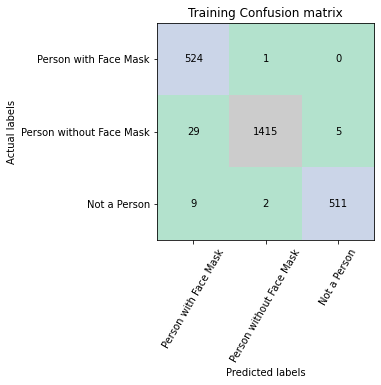

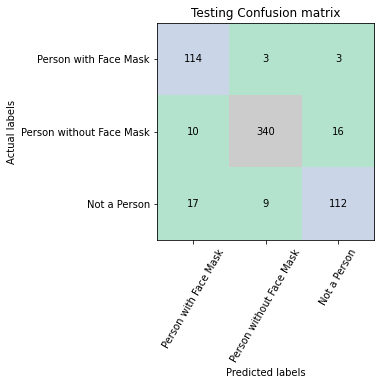

In [19]:
# If the value of is_data_preloaded
# is True which means program reads pre-loaded data from the directory, otherwise it generates
# the data and loads it. While the True value of is_model_saved parameter indicates that
# program reads model from the directory which is pre stored and if the parameter is set as 
# False then it creates new model, trains the model and then it becomes available for 
# further use such as in evaluation process.

run_program(is_data_preloaded=True, is_model_saved=True)